## Step 1: 데이터 로딩

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:03<00:00, 3260859.02it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 347230.98it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3193738.86it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4494109.17it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

torch.Size([64, 1, 28, 28]) torch.Size([64])


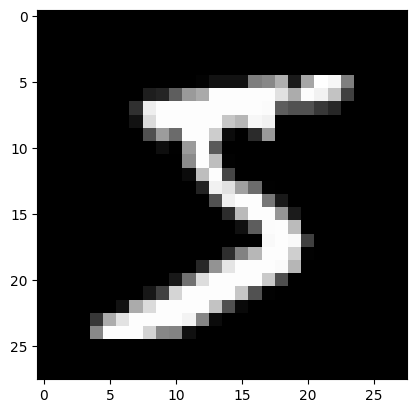

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt

# 데이터셋을 텐서로 변환
transform = transforms.ToTensor()

# Train 데이터 로딩
trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Test 데이터 로딩
testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Train 데이터 로더
batch_size = 64
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

# Test 데이터 로더
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

# 데이터 형태 확인
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

# 이미지 예시 시각화
plt.imshow(trainset[0][0][0], cmap='gray')
plt.show()

## Step 2: 모델 정의

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # Output: 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No activation here, CrossEntropyLoss includes softmax
        return x

## Step 3: 손실 함수와 옵티마이저 설정

In [5]:
import torch.optim as optim

model = Net().to('cuda')  # GPU 사용
loss_fn = nn.CrossEntropyLoss()  # MSE 대신 CrossEntropyLoss 사용
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Step 4: 학습 및 평가 함수

In [6]:
def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    model.eval()  # 평가 모드로 설정
    with torch.no_grad():  # Gradient 계산 안 함
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            preds = model(inputs)
            preds = torch.argmax(preds, dim=-1)  # 예측값의 인덱스 (클래스)

            cnt += labels.shape[0]
            acc += (labels == preds).sum().item()

    return acc / cnt

In [7]:
n_epochs = 100
train_accuracies = []
test_accuracies = []

for epoch in range(n_epochs):
    model.train()  # 학습 모드로 설정
    running_loss = 0.0

    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        # 옵티마이저 초기화
        optimizer.zero_grad()

        # Forward
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # Backward
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # 매 에포크마다 train과 test 정확도 계산
    train_acc = accuracy(model, trainloader)
    test_acc = accuracy(model, testloader)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}, '
          f'Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')


Epoch 1, Loss: 0.1727, Train Accuracy: 0.9837, Test Accuracy: 0.9824
Epoch 2, Loss: 0.0482, Train Accuracy: 0.9906, Test Accuracy: 0.9876
Epoch 3, Loss: 0.0330, Train Accuracy: 0.9918, Test Accuracy: 0.9877
Epoch 4, Loss: 0.0238, Train Accuracy: 0.9960, Test Accuracy: 0.9902
Epoch 5, Loss: 0.0185, Train Accuracy: 0.9953, Test Accuracy: 0.9898
Epoch 6, Loss: 0.0148, Train Accuracy: 0.9959, Test Accuracy: 0.9895
Epoch 7, Loss: 0.0106, Train Accuracy: 0.9972, Test Accuracy: 0.9909
Epoch 8, Loss: 0.0099, Train Accuracy: 0.9979, Test Accuracy: 0.9896
Epoch 9, Loss: 0.0077, Train Accuracy: 0.9970, Test Accuracy: 0.9915
Epoch 10, Loss: 0.0082, Train Accuracy: 0.9979, Test Accuracy: 0.9901
Epoch 11, Loss: 0.0055, Train Accuracy: 0.9974, Test Accuracy: 0.9907
Epoch 12, Loss: 0.0056, Train Accuracy: 0.9991, Test Accuracy: 0.9907
Epoch 13, Loss: 0.0036, Train Accuracy: 0.9984, Test Accuracy: 0.9899
Epoch 14, Loss: 0.0053, Train Accuracy: 0.9987, Test Accuracy: 0.9910
Epoch 15, Loss: 0.0041, Train

## Step 5: 정확도 시각화

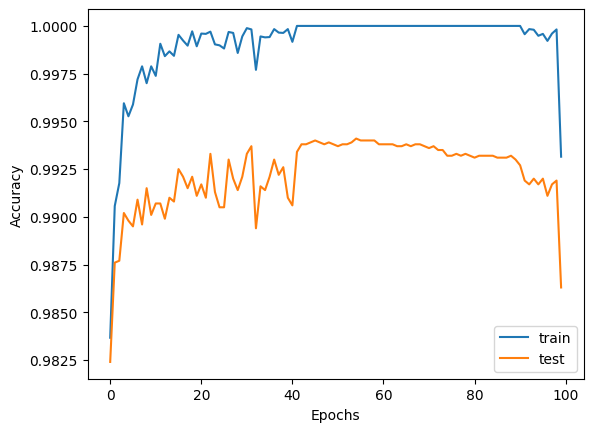

In [8]:
import numpy as np

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
    x = np.arange(len(train_accs))

    plt.plot(x, train_accs, label=label1)
    plt.plot(x, test_accs, label=label2)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 정확도 시각화
plot_acc(train_accuracies, test_accuracies)


## Step 6: 모델 예측과 실제 정답 출력

In [9]:
# 모델이 예측한 것과 실제 정답을 10개 비교하여 출력
model.eval()  # 모델을 평가 모드로 전환
with torch.no_grad():  # 학습 중이 아님을 선언
    # Test 데이터에서 첫 10개의 이미지를 사용하여 예측
    for idx in range(10):
        image, label = testset[idx][0], testset[idx][1]  # 이미지와 실제 정답
        image = image.unsqueeze(0).to('cuda')  # (1, 1, 28, 28)로 모양 변경 후 GPU로 이동

        output = model(image)  # 모델 예측
        pred = torch.argmax(output, dim=1).item()  # 가장 높은 값을 가진 클래스 예측

        print(f'이미지 {idx+1}: 모델 예측 = {pred}, 실제 정답 = {label}')


이미지 1: 모델 예측 = 7, 실제 정답 = 7
이미지 2: 모델 예측 = 2, 실제 정답 = 2
이미지 3: 모델 예측 = 1, 실제 정답 = 1
이미지 4: 모델 예측 = 0, 실제 정답 = 0
이미지 5: 모델 예측 = 4, 실제 정답 = 4
이미지 6: 모델 예측 = 1, 실제 정답 = 1
이미지 7: 모델 예측 = 4, 실제 정답 = 4
이미지 8: 모델 예측 = 9, 실제 정답 = 9
이미지 9: 모델 예측 = 5, 실제 정답 = 5
이미지 10: 모델 예측 = 9, 실제 정답 = 9
